In [1]:
%load_ext autoreload
%autoreload 2

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [303]:
from synthetic_data import generate_cqr_data, indicator_matrix

In [387]:
# generate data
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=123)

# fit a fourth order polynomial
poly = PolynomialFeatures(4)
reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

# score function is residual
score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

# coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
eps = 0.5
disc = np.arange(0, 5 + eps, eps)

def phi_fn(x):
    disc = 0.5
    return indicator_matrix(x, np.arange(0,5 + disc,disc))

In [388]:
# sanity check with quantile regression fit to calibration data
import cvxpy as cp

eta = cp.Variable(shape=len(x_calib))

phi_calib = phi_fn(x_calib)
scores_calib = score_fn(x_calib, y_calib)
scores_test = score_fn(x_test, y_test)

constraints = [
    (0.95 - 1) <= eta,
    0.95 >= eta,
    eta.T @ phi_calib == 0
]
prob = cp.Problem(
    cp.Minimize(-1 * cp.sum(cp.multiply(eta, cp.vec(scores_calib)))),
    constraints
)
prob.solve(solver=cp.MOSEK)

beta_upper = prob.constraints[-1].dual_value

constraints = [
    (0.05 - 1) <= eta,
    0.05 >= eta,
    eta.T @ phi_calib == 0
]
prob = cp.Problem(
    cp.Minimize(-1 * cp.sum(cp.multiply(eta, cp.vec(scores_calib)))),
    constraints
)
prob.solve(solver=cp.MOSEK)

beta_lower = prob.constraints[-1].dual_value

# sanity check coverage
upper_baseline = phi_fn(x_test) @ beta_upper
lower_baseline = phi_fn(x_test) @ beta_lower

coverage = ((upper_baseline >= scores_test) & (lower_baseline <= scores_test)).flatten()
ind12 = ((x_test <= 2) & (x_test >= 1)).flatten()
ind34 = ((x_test <= 4) & (x_test >= 3)).flatten()

print("marginal", np.mean(coverage))
print("[1,2]", np.mean(coverage[ind12]))
print("[3,4]", np.mean(coverage[ind34]))

marginal 0.858
[1,2] 0.8877551020408163
[3,4] 0.826530612244898


In [399]:
from gcc import GCC
from tqdm import tqdm


def run_trial(seed):
    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=seed)

    # fit a fourth order polynomial
    poly = PolynomialFeatures(4)
    reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

    # score function is residual
    score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
    score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
    score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

    # coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
    eps = 0.5
    disc = np.arange(0, 5 + eps, eps)

    def phi_fn(x):
        disc = 0.5
        return indicator_matrix(x, np.arange(0, 5 + disc, disc))
    alpha = 0.1

    cond_conf_ub = GCC(score_fn, phi_fn)
    cond_conf_ub.set_function_class(1 - alpha/2, x_calib, y_calib, infinite_params = {})

    cond_conf_lb = GCC(score_fn, phi_fn)
    cond_conf_lb.set_function_class(alpha/2, x_calib, y_calib, infinite_params = {})

    n_test = 500

    lbs = np.zeros((n_test,))
    ubs = np.zeros((n_test,))
    i = 0
    
    x_test = x_test[0:n_test]
    y_test = y_test[0:n_test]


    for x_t in x_test:
        res = cond_conf_lb.predict(x_t, score_inv_fn_lb)
        lbs[i] = res[0]
        res = cond_conf_ub.predict(x_t, score_inv_fn_ub)
        ubs[i] = res[1]
        i += 1
        
    q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                    np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)
    scores_test = np.abs(y_test - reg.predict(poly.fit_transform(x_test)))

    cov_split = scores_test > q
    cov_test = np.logical_or(y_test > ubs, y_test < lbs)
    
    i_12 = ((x_test >= 1) & (x_test <= 2)).flatten()
    i_34 = ((x_test >= 3) & (x_test <= 4)).flatten()
    
    cov_marg = [np.mean(cov_split), np.mean(cov_test)]
    cov_12 = [np.mean(cov_split[i_12]), np.mean(cov_test[i_12])]
    cov_34 = [np.mean(cov_split[i_34]), np.mean(cov_test[i_34])]
    return cov_marg, cov_12, cov_34


m = []
one = []
two = []
for trial in tqdm(range(1)):
    marginal, g1, g2 = run_trial(seed=trial)
    m.append(marginal)
    one.append(g1)
    two.append(g2)

print(np.mean(m, axis=0), np.mean(one, axis=0), np.mean(two, axis=0))

import pickle

with open('group_results.pkl', 'wb') as fp:
    pickle.dump((m, one, two), fp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:08<00:00, 248.75s/it]

[0.124 0.13 ] [0.18518519 0.17592593] [0.04444444 0.05555556]


In [398]:
np.mean(m, axis=0)

array([0.124, 0.13 ])

In [382]:
cov_test = np.logical_and(y_test <= ubs, y_test >= lbs)

scores_test = np.abs(y_test - reg.predict(poly.fit_transform(x_test)))
Phi_test = Phi_fn(x_test)

q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

coverageData = pd.DataFrame({'Method': ['Split','Conditional'], 'Range' : ['Marginal','Marginal'], 
                            'Miscoverage': [1 - sum(scores_test <= q)/len(scores_test),
                                         1 - sum(cov_test)/len(cov_test)]})


i_12 = ((x_test >= 0.5) & (x_test <= 1.5)).flatten()
i_34 = ((x_test >= 3.5) & (x_test <= 4.5)).flatten()
        
coverageData = pd.concat([coverageData,
                        pd.DataFrame({'Method': ['Split','Conditional'], 'Range' : ['[1, 2]','[1, 2]'], 
                            'Miscoverage': [np.sum(scores_test[i_12] > q)/np.sum(i_12),
                                         1 - np.sum(cov_test[i_12])/np.sum(i_12)]})
                         ], axis = 0)
coverageData = pd.concat([coverageData,
                        pd.DataFrame({'Method': ['Split','Conditional'], 'Range' : ['[3, 4]','[3, 4]'], 
                            'Miscoverage': [np.sum(scores_test[i_34] > q)/np.sum(i_34),
                                         1 - np.sum(cov_test[i_34])/np.sum(i_34)]})
                         ], axis = 0)

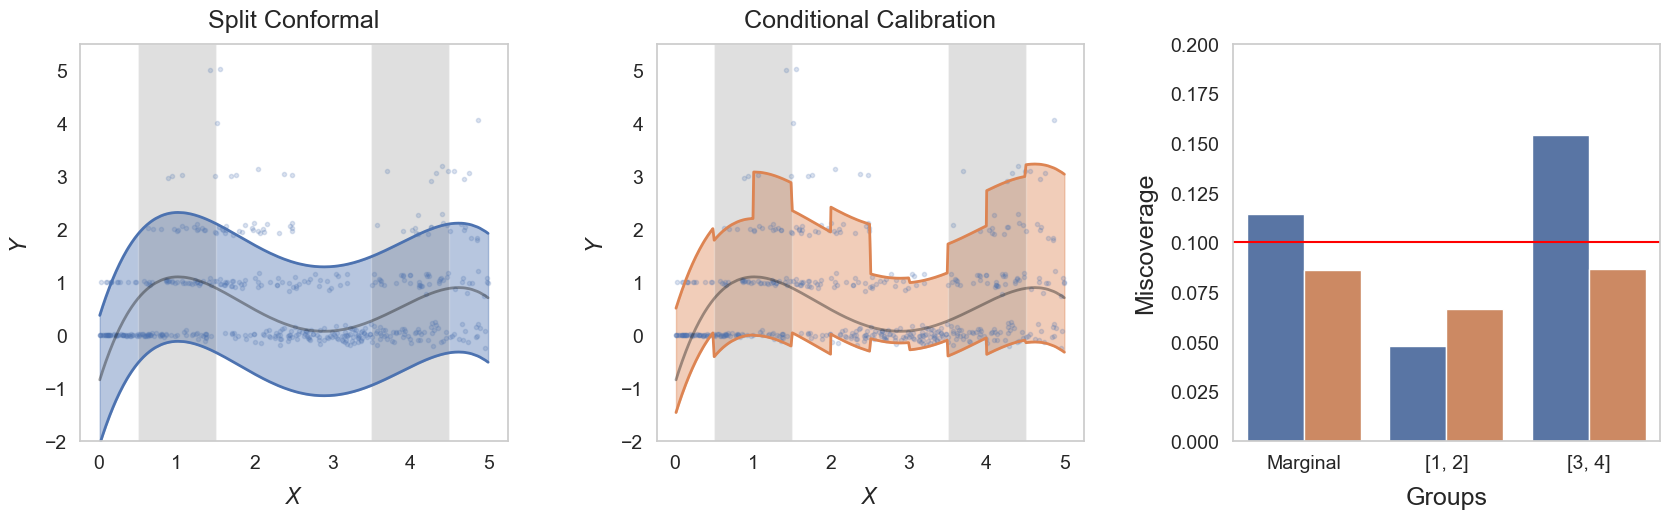

In [383]:
#fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(17.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb = lbs[sort_order]
ub = ubs[sort_order]


ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=2, color='k', alpha=0.4)
ax1.plot(x_test_s, y_test_hat + q, color=cp[0], lw=2)
ax1.plot(x_test_s, y_test_hat - q, color=cp[0], lw=2)
ax1.fill_between(x_test_s.flatten(), y_test_hat - q, y_test_hat + q, 
                 color=cp[0], alpha=0.4, label='split prediction interval')
ax1.set_ylim(-2,5.5)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)

ax1.axvspan(1, 2, facecolor='grey', alpha=0.25)
ax1.axvspan(3, 4, facecolor='grey', alpha=0.25)

ax2 = fig.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, y_test_hat, color='k', alpha=0.4, lw=2)
ax2.plot(x_test_s, ub, color=cp[1], lw=2)
ax2.plot(x_test_s, lb, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), lb, 
                 ub, 
                 color=cp[1], alpha=0.4, label='conditional calibration')
ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)

ax2.axvspan(1, 2, facecolor='grey', alpha=0.25)
ax2.axvspan(3, 4, facecolor='grey', alpha=0.25)

ax3 = fig.add_subplot(1, 3, 3)
f = sns.barplot(
    coverageData, 
    x='Range', 
    y='Miscoverage',
    hue='Method',
    palette=cp,
    ax = ax3
)
f.axhline(0.1, color='red')
f.legend_.remove()
ax3.set_ylabel("Miscoverage", fontsize=18, labelpad=10)
ax3.set_xlabel("Groups", fontsize=18, labelpad=10)
ax3.set_ylim(0.,0.2)
ax3.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(pad=3)

# plt.savefig('cqrDataComparison_auto.pdf')